In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from cvxopt import matrix, solvers
from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from numba import njit

import neal

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import Classic_SVM_CVXOPT_Linear as CL
import Classic_SVM_CVXOPT_Gaussian as CG
import Quantum_SVM_Linear_neal as QL
import Quantum_SVM_Gaussian_neal as QG

In [2]:
#데이터 및 상수 생성

n_train = 50

X, Y = make_circles(n_samples = 200, noise=0.1, random_state = 40)
X_train = X[:n_train, :]
X_test = X[n_train:, :]
y_train = Y[:n_train] 
y_test = Y[n_train:]

y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

N_train = X_train.shape[0]

In [3]:
B_list = [5]*30

K_list = [3]*30

xi_list = [1]*30

gamma_list = [1]*30

C_list = [10*c for c in range(1, 31)]

In [4]:
print(C_list[1])

20


In [5]:
C_acc_list = []
C_auroc_list = []
C_auprc_list = []

Q_acc_Max = []
Q_auroc_Max = []
Q_auprc_Max = []

Qgap_acc_Max = []
Qgap_auroc_Max = []
Qgap_auprc_Max = []

Cgap_acc_list   = []
Cgap_auroc_list = []
Cgap_auprc_list = []

Qgap_acc_train_list = []
Qgap_auroc_train_list = []
Qgap_auprc_train_list = []

Qgap_acc_Max_list = []
Qgap_auroc_Max_list = []
Qgap_auprc_Max_list = []

C_Loss_train_mean = []
C_Loss_test_mean = []

Q_Loss_train_mean_Min = []
Q_Loss_test_mean_Min = []

nth_alpha = []
Sum_evaluate = []

In [6]:
for i  in range(len(gamma_list)):
    
    B = B_list[i]
    K = K_list[i]
    xi = xi_list[i]
    gamma = gamma_list[i]
    C = C_list[i]

    Q_acc_train_list = []
    Q_auroc_train_list = []
    Q_auprc_train_list = []

    Q_acc_test_list = []
    Q_auroc_test_list = []
    Q_auprc_test_list = []

    Qgap_acc_list = []
    Qgap_auroc_list = []
    Qgap_auprc_list = []

    Q_Loss_train_mean = []
    Q_Loss_test_mean = []

    #Classic SVM
    # for k in range(1,K+1):
    #     C += B**k

    P, q, G, h, A, b, K_train_train = CG.Solver_Parameter(N_train, X_train, y_train, gamma, C)
    sol = CG.Solver_SVM(P, q, G, h, A, b)

    alpha = np.array(sol['x']).reshape(-1)

    acc_train, auroc_train, auprc_train, C_scores_train = CG.evaluate_train(
            y_train,
            alpha,
            K_train_train,
            C
        )

    acc_test, auroc_test, auprc_test = QG.evaluate_test(
        y_test,
        CG.Test_evlauation(X_train, X_test, y_train, alpha, K_train_train, gamma, C)
    )

    C_acc_list.append(acc_test)
    C_auroc_list.append(auroc_test)
    C_auprc_list.append(auprc_test)

    Cgap_acc, Cgap_auroc, Cgap_auprc = CG.Evaluate_Overfitting(acc_train, acc_test, auroc_train, auroc_test, auprc_train, auprc_test)
    Cgap_acc_list.append(Cgap_acc)
    Cgap_auroc_list.append(Cgap_auroc)
    Cgap_auprc_list.append(Cgap_auprc)

    Loss_train, Loss_test= CG.Hinge_Loss(X_train, X_test, y_train, y_test, alpha, K_train_train, C_scores_train, gamma, C)

    C_Loss_train_mean.append(Loss_train)
    C_Loss_test_mean.append(Loss_test)

    #Quantum SVM
    K_train_train, Q = QG.Q_metric(N_train, X_train, y_train, B, K, xi, gamma)

    sol = QG.neal_Solver(Q)

    top_k = len(sol)
    if top_k > 20:
        top_k = 20 

    for n_th in range(top_k):

        x_opt, energy = QG.Solution(sol, top_k, n_th)

        alpha = QG.alpha_value(N_train, x_opt, B, K)

        Q_acc_train, Q_auroc_train, Q_auprc_train, Q_scores_train = QG.evaluate_train(
            y_train,
            alpha,
            K_train_train,
            C
        )

        Q_acc_test, Q_auroc_test, Q_auprc_test = QG.evaluate_test(
            y_test,
            QG.Test_evlauation(X_train, X_test, y_train, alpha, K_train_train, gamma, C)
        )

        Q_acc_train_list.append(Q_acc_train)
        Q_auroc_train_list.append(Q_auroc_train)
        Q_auprc_train_list.append(Q_auprc_train)

        Q_acc_test_list.append(Q_acc_test)
        Q_auroc_test_list.append(Q_auroc_test)
        Q_auprc_test_list.append(Q_auprc_test)

        Q_gap_acc, Q_gap_auroc, Q_gap_auprc = QG.Evaluate_Overfitting(Q_acc_train, Q_acc_test, Q_auroc_train, Q_auroc_test, Q_auprc_train, Q_auprc_test)

        Qgap_acc_list.append(Q_gap_acc)
        Qgap_auroc_list.append(Q_gap_auroc)
        Qgap_auprc_list.append(Q_gap_auprc)

        Loss_train, Loss_test= QG.Hinge_Loss(X_train, X_test, y_train, y_test, alpha, K_train_train, Q_scores_train, gamma, C)

        Q_Loss_train_mean.append(Loss_train)
        Q_Loss_test_mean.append(Loss_test)

    Q_acc_Max.append(max(Q_acc_test_list))
    Q_auroc_Max.append(max(Q_auroc_test_list))
    Q_auprc_Max.append(max(Q_auprc_test_list))
    
    Qgap_acc_Max.append(max(Qgap_acc_list))
    Qgap_auroc_Max.append(max(Qgap_auroc_list))
    Qgap_auprc_Max.append(max(Qgap_auprc_list))

    Q_Loss_train_mean_Min.append(min(Q_Loss_train_mean))
    Q_Loss_test_mean_Min.append(min(Q_Loss_test_mean))

     pcost       dcost       gap    pres   dres
 0: -7.9784e+01 -2.1132e+03  2e+03  9e-16  4e-15
 1: -1.4294e+02 -4.1728e+02  3e+02  3e-15  4e-15
 2: -2.0680e+02 -2.7411e+02  7e+01  1e-14  4e-15
 3: -2.2915e+02 -2.4881e+02  2e+01  2e-15  5e-15
 4: -2.3641e+02 -2.3885e+02  2e+00  7e-15  5e-15
 5: -2.3739e+02 -2.3761e+02  2e-01  2e-15  5e-15
 6: -2.3748e+02 -2.3748e+02  6e-03  4e-15  5e-15
 7: -2.3748e+02 -2.3748e+02  3e-04  5e-15  6e-15
 8: -2.3748e+02 -2.3748e+02  8e-06  4e-15  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0630e+02 -7.1336e+03  7e+03  1e-14  9e-15
 1: -1.5706e+02 -1.0463e+03  9e+02  9e-15  7e-15
 2: -3.3692e+02 -5.2787e+02  2e+02  4e-15  7e-15
 3: -4.0128e+02 -4.5228e+02  5e+01  1e-14  8e-15
 4: -4.1970e+02 -4.3126e+02  1e+01  2e-14  1e-14
 5: -4.2421e+02 -4.2549e+02  1e+00  7e-15  1e-14
 6: -4.2476e+02 -4.2489e+02  1e-01  4e-15  1e-14
 7: -4.2481e+02 -4.2481e+02  2e-03  7e-15  8e-15
 8: -4.2481e+02 -4.2481e+02  2e-05  7e-15  8e-1

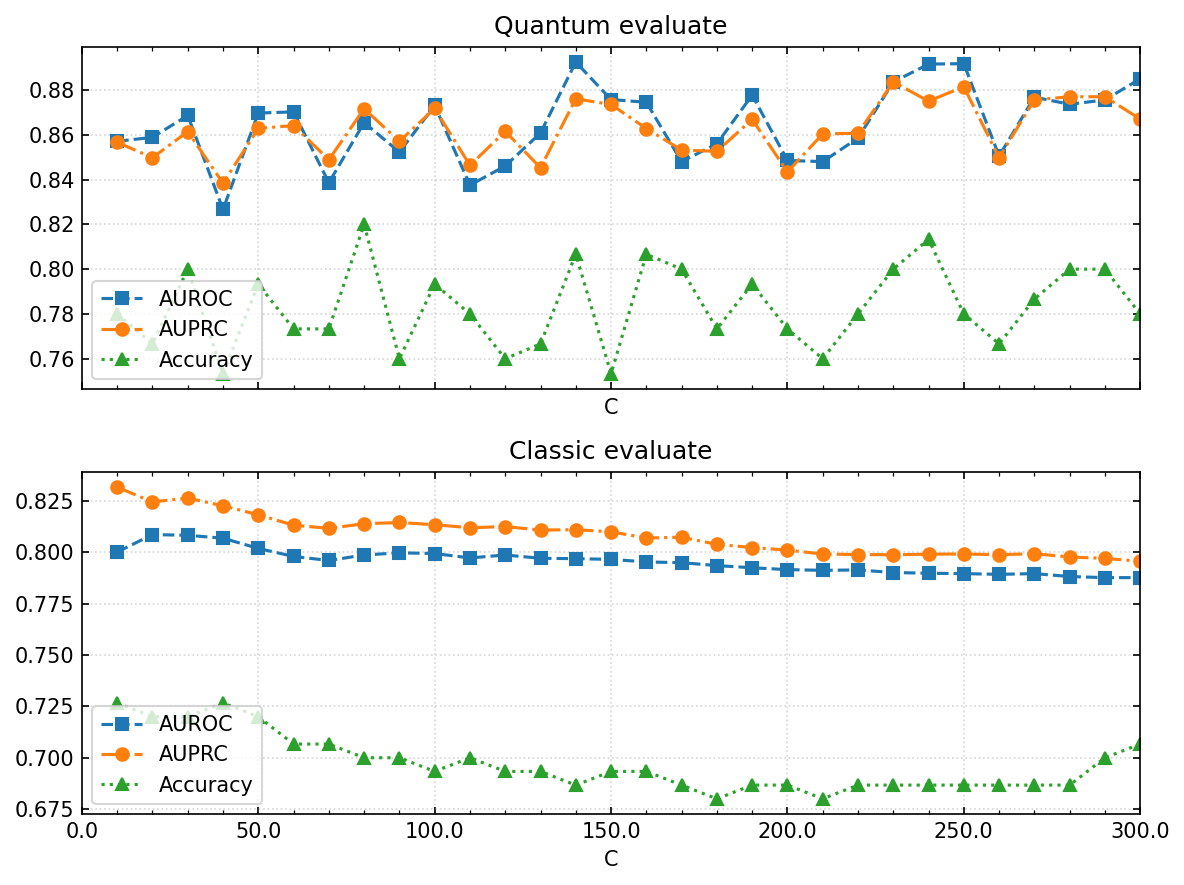

In [12]:
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 6),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

axes[0].plot(C_list, Q_auroc_Max, 's--', label="AUROC")
axes[0].plot(C_list, Q_auprc_Max, 'o-.', label="AUPRC")
axes[0].plot(C_list, Q_acc_Max, '^:', label="Accuracy")
axes[0].set_title("Quantum evaluate")
axes[0].set_xlabel("C")
# axes[0].set_ylim(0, 1)
# axes[0].set_yscale('log')
axes[0].set_xlim(0, 300)
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[0].xaxis.set_minor_locator(mticker.MultipleLocator(10))
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[0].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].legend(loc = "lower left")

axes[1].plot(C_list, C_auroc_list, 's--', label="AUROC")
axes[1].plot(C_list, C_auprc_list, 'o-.', label="AUPRC")
axes[1].plot(C_list, C_acc_list, '^:', label="Accuracy")
axes[1].set_title("Classic evaluate")
axes[1].set_xlabel("C")
# axes[1].set_ylim(0, 1)
# axes[1].set_yscale('log')
axes[1].set_xlim(0, 300)
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[1].xaxis.set_minor_locator(mticker.MultipleLocator(10))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[1].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[1].legend(loc = "lower left")

plt.tight_layout()

plt.show()

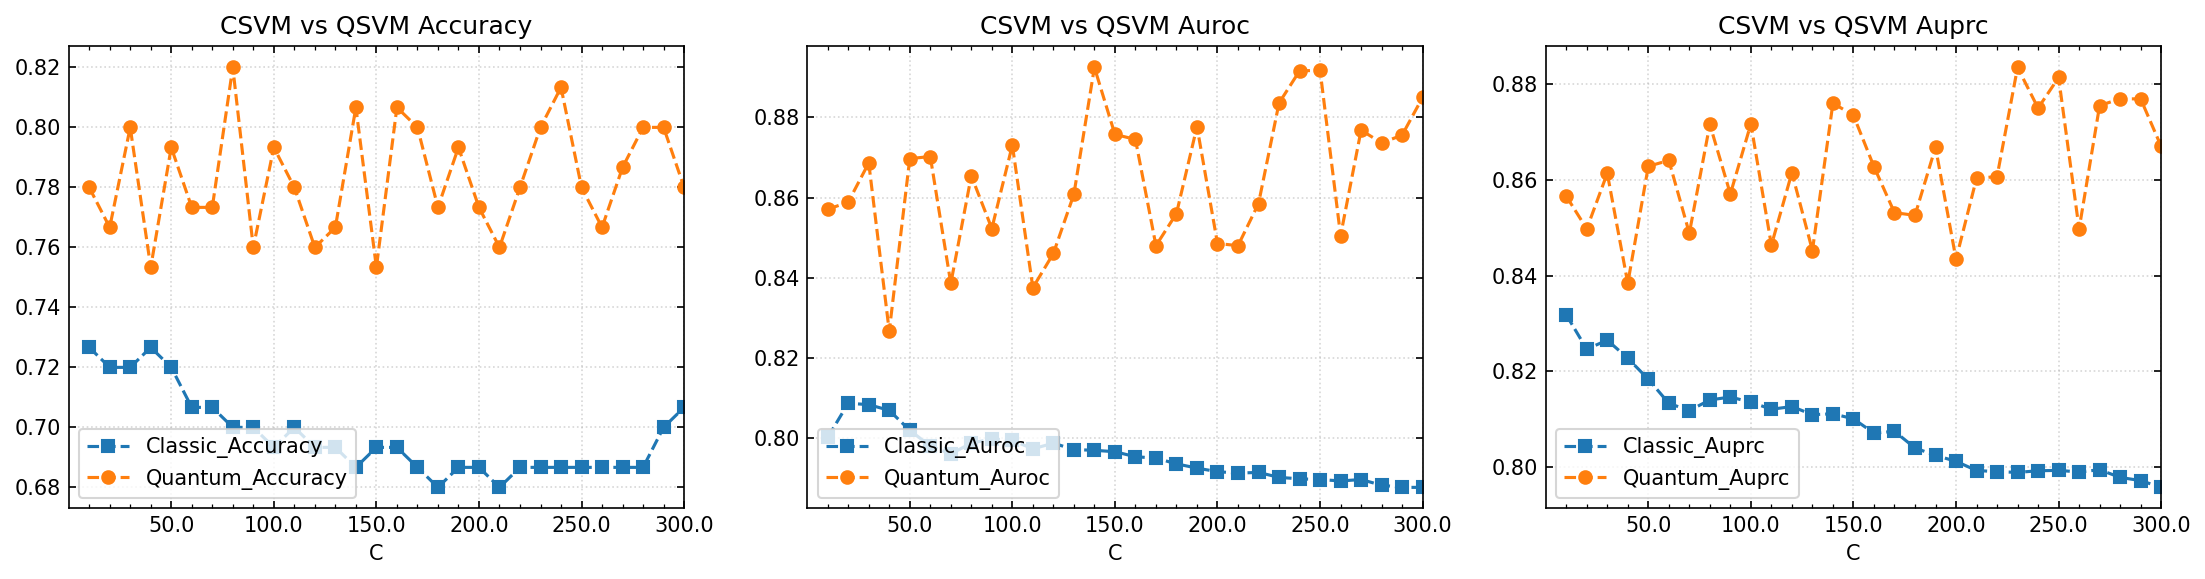

In [13]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 4),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

axes[0].plot(C_list, C_acc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Accuracy")
axes[0].plot(C_list, Q_acc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Accuracy")
axes[0].set_title("CSVM vs QSVM Accuracy")
axes[0].set_xlabel("C")
# axes[0].set_ylim(0, 1)
# axes[0].set_yscale('log')
axes[0].set_xlim(1e-6, 300)
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[0].xaxis.set_minor_locator(mticker.MultipleLocator(10))
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[0].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].legend(loc = "lower left")

axes[1].plot(C_list, C_auroc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Auroc")

axes[1].plot(C_list, Q_auroc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Auroc")

axes[1].set_title("CSVM vs QSVM Auroc")
axes[1].set_xlabel("C")
# axes[1].set_ylim(0, 1)
# axes[1].set_yscale('log')
axes[1].set_xlim(1e-6, 300)
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[1].xaxis.set_minor_locator(mticker.MultipleLocator(10))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[1].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[1].legend(loc = "lower left")

axes[2].plot(C_list, C_auprc_list,
    marker='s', linestyle='--',
    color='tab:blue',
    label="Classic_Auprc")

axes[2].plot(C_list, Q_auprc_Max,
    marker='o', linestyle='--',
    color='tab:orange',
    label="Quantum_Auprc")

axes[2].set_title("CSVM vs QSVM Auprc")
axes[2].set_xlabel("C")
# axes[2].set_ylim(0, 1)
# axes[2].set_yscale('log')
axes[2].set_xlim(1e-6, 300)
axes[2].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[2].xaxis.set_minor_locator(mticker.MultipleLocator(10))
axes[2].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[2].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[2].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[2].legend(loc = "lower left")

In [9]:
# axes[].set_xlim(0, 3)
# axes[].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
# axes[].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
# axes[].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
# axes[].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
# axes[].tick_params(axis='both', which='both', direction='in', top=True, right=True)

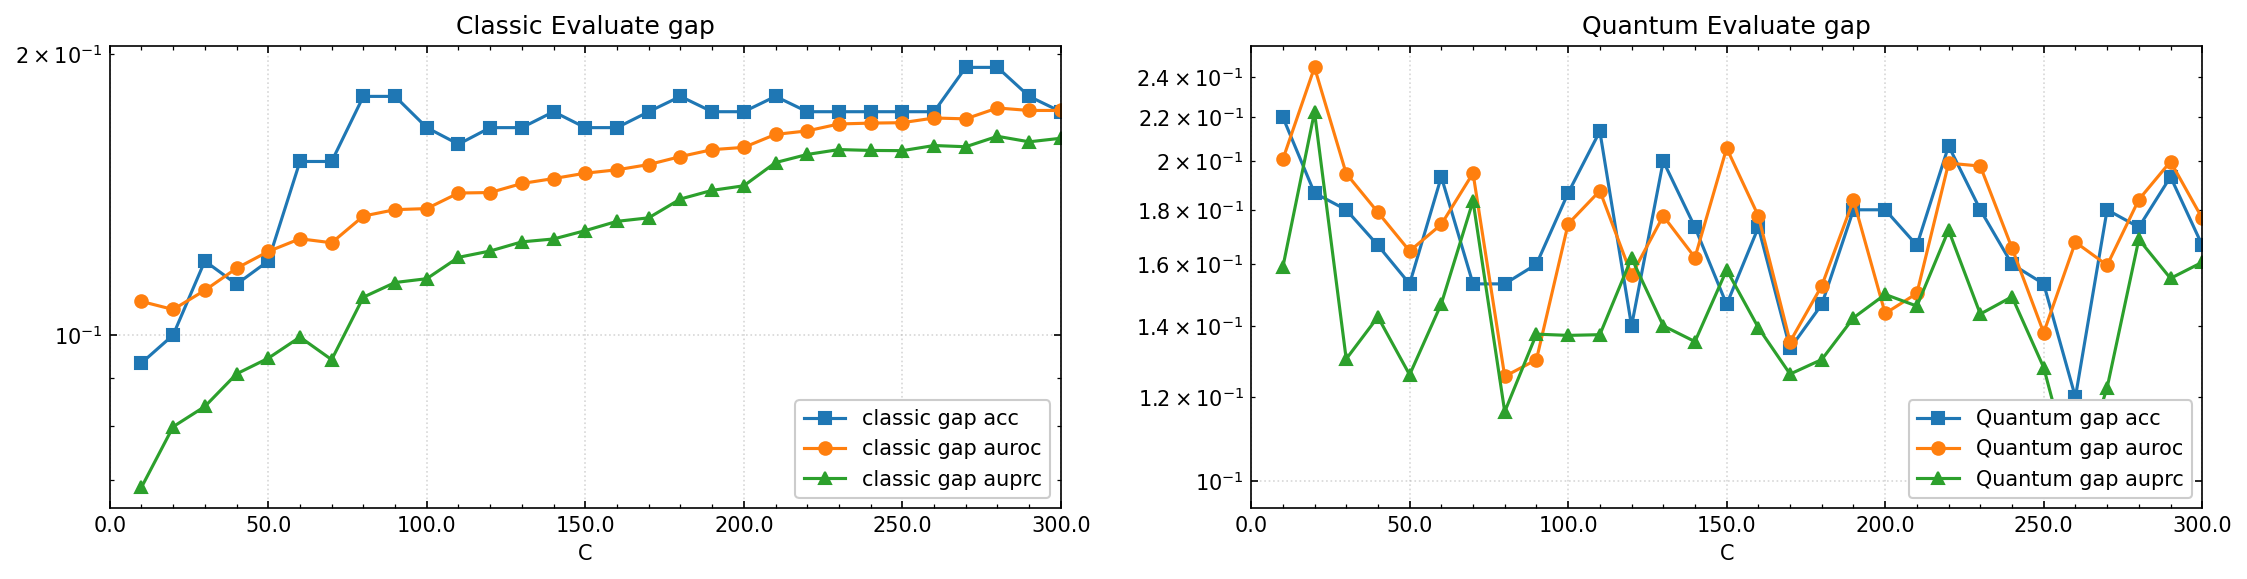

In [10]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 4),
    dpi=150,
    sharex=True
)

# =========================
# 공통 x축 설정
# =========================
def setup_gamma_axis(ax):
    ax.set_xlim(0, 300)

    # ✔ 0.5 간격 → 큰 눈금 (major)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))

    # ✔ 0.1 간격 → 작은 눈금 (minor)
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))

    # (선택) 큰 눈금만 라벨 표시
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    # ✔ 격자는 큰 눈금 위치에만
    ax.grid(
        which='major',
        linestyle=':',
        linewidth=0.8,
        alpha=0.5
    )

    # ✔ 눈금: 위/아래/좌/우 + 안쪽
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True
    )

# =========================
# Left: Classic
# =========================
axes[0].plot(C_list, Cgap_acc_list, "s-", label="classic gap acc")
axes[0].plot(C_list, Cgap_auroc_list, "o-", label="classic gap auroc")
axes[0].plot(C_list, Cgap_auprc_list, "^-", label="classic gap auprc")

axes[0].set_title("Classic Evaluate gap")
axes[0].set_yscale('log')
# axes[0].set_ylim(1e-6, 0.3)
axes[0].set_xlabel("C")

setup_gamma_axis(axes[0])

axes[0].legend(loc="lower right", framealpha=1)

# =========================
# Right: Quantum
# =========================
axes[1].plot(C_list, Qgap_acc_Max, "s-", label="Quantum gap acc")
axes[1].plot(C_list, Qgap_auroc_Max, "o-", label="Quantum gap auroc")
axes[1].plot(C_list, Qgap_auprc_Max, "^-", label="Quantum gap auprc")

axes[1].set_title("Quantum Evaluate gap")
# axes[1].set_ylim(1e-6, 0.3)
axes[1].set_yscale('log')
axes[1].set_xlabel("C")

setup_gamma_axis(axes[1])

axes[1].legend(loc="lower right", framealpha=1)

plt.show()

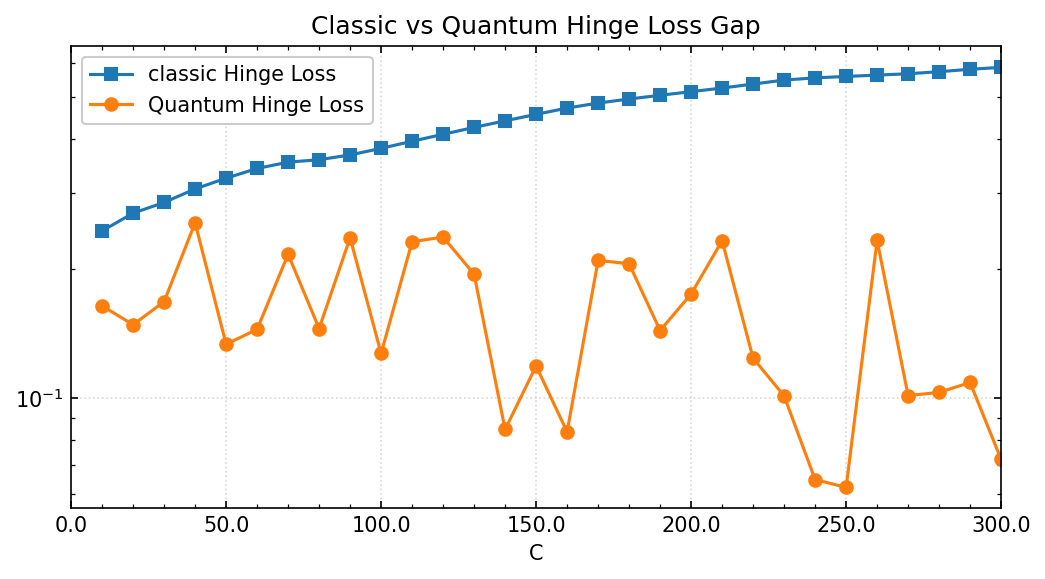

In [11]:
C_Loss = [(C_Loss_test_mean[i] - C_Loss_train_mean[i]) for i in range(len(C_Loss_train_mean))]
Q_Loss = [(Q_Loss_test_mean_Min[i] - Q_Loss_train_mean_Min[i]) for i in range(len(Q_Loss_train_mean_Min))]

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

ax.plot(C_list, C_Loss, "s-", label="classic Hinge Loss")
ax.plot(C_list, Q_Loss, "o-", label="Quantum Hinge Loss")

ax.set_title("Classic vs Quantum Hinge Loss Gap")
# ax.set_ylim(1e-6, 1)
ax.set_yscale('log')
ax.set_xlabel("C")

# x축 범위 (0~3만 쓰는 거면 0~3만 남김)
ax.set_xlim(0, 300)

# x축: 0.5는 큰 눈금(major), 0.1은 작은 눈금(minor)
ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# 격자: 큰 눈금 위치에만, 점선, 투명도 50%
ax.grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)

# 위/오른쪽에도 눈금 + 안쪽 방향
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.legend(loc="upper left", framealpha=1)

plt.show()